In [ ]:
# https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4
# https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
# https://medium.com/geekculture/boost-your-image-classification-model-with-pretrained-vgg-16-ec185f763104
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


print("Current CUDA device:", tf.test.gpu_device_name())


# load the labaled data
#no headers on csv will references by index 
train_labeled_data = pd.read_csv('MURA-v1.1/train_labeled_studies.csv', header=None)
train_images_paths = pd.read_csv('MURA-v1.1/train_image_paths.csv', header=None)

#resize all images and process images as a numpy array
def process_train_images(img_path):
    img = load_img(img_path, target_size = (128,128)) #resize to 244 to keep consistant with Michelle's code
    img_arr = img_to_array(img)
    return img_arr


train_images = []
train_labels = []

# iterate through dir to correspond img to the correct label
#TODO: discuss this portion with Michelle 
    #@Michelle I wasnt able to load my model on the same notebook as yours ... I  kept running out of resources for some reason??
    # I dont think this includes the data aug you did .. 
    #please feel free to edit this part to optmize 
for dir_path, label in zip(train_labeled_data[0], train_labeled_data[1]):
    image_to_label = train_images_paths[0][train_images_paths[0].str.startswith(dir_path)].values
    # process img with correct label
    for img_path in image_to_label:
        img_array = process_train_images(img_path)
        train_images.append(img_array)
        train_labels.append(label)



#must be transformed to  np arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

#the shape of the collected train
print("train images shape ->", train_images.shape)
print("train labels array shape ->", train_labels.shape)
#print(train_labeled_data.head())



In [9]:
#this is the VGG model with weights already pretrained from imagenet 
#had to decrease size of images due to computational resources 
#did not include the fully connected layers because this is a different task compared to imagenet tasks

vmodel = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vmodel.trainable = False

print(vmodel.summary())
print("Current CUDA device:", tf.test.gpu_device_name())

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Current CUDA device: /device:GPU:0


2024-04-17 04:49:09.759013: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:0 with 12680 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:4f:00.0, compute capability: 8.9
2024-04-17 04:49:09.759391: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:1 with 30373 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:52:00.0, compute capability: 8.9
2024-04-17 04:49:09.759860: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:2 with 18995 MB memory:  -> device: 2, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:56:00.0, compute capability: 8.9
2024-04-17 04:49:09.760109: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:3 with 15245 MB memory:  -> device: 3, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:57:00.0, compute capability: 8.9
2024-04-17 04:49:09.760357: I tensorflow/cor

In [13]:
#adding the last layers for our specifc tasks
#https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4
#the number of layers and neurons are arbtituary we can add or remove amount

#numbers 58, 28, 7, 1 represent the number of neurons
from tensorflow.keras import layers, models

#TODO: Explore ways to adjust these parameters so it can converge 
#less or more layers, edit numbers of neurons.
#more neurons means problems is very complex 

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(58, activation='relu')
dense_layer_2 = layers.Dense(28, activation='relu')
dense_layer_3 = layers.Dense(7, activation='relu')
prediction_layer = layers.Dense(1, activation='sigmoid') #binary classification

model = models.Sequential([
    vmodel,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

model.summary()


#optimzer was very easy to include
#article includes early stopping to generalize data more and prevent overfitting maybe this is something we can do as a stretch goal
#TODO: add the Kappa metric
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)

#dispaly model summary of our new model
model.summary()
print("Current CUDA device:", tf.test.gpu_device_name())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Current CUDA device: /device:GPU:0


2024-04-17 05:00:01.657839: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:0 with 12680 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:4f:00.0, compute capability: 8.9
2024-04-17 05:00:01.658236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:1 with 30373 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:52:00.0, compute capability: 8.9
2024-04-17 05:00:01.658601: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:2 with 18995 MB memory:  -> device: 2, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:56:00.0, compute capability: 8.9
2024-04-17 05:00:01.658968: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:3 with 15245 MB memory:  -> device: 3, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:57:00.0, compute capability: 8.9
2024-04-17 05:00:01.659328: I tensorflow/cor

In [14]:
#TRAIN MODEL HERE

#realized i have to convert the labels to binary
train_labels_binary = [1 if label != 0 else 0 for label in train_labels]

#now binary to numpy array 
train_labels_binary = np.array(train_labels_binary)

#confirm shape is correct
print("train_labels_binary shape ->", train_labels_binary.shape)


#switch device for training
with tf.device('/gpu:0'):
    training_results = model.fit(train_images, train_labels_binary, batch_size = 64, epochs = 30)
    print("Current CUDA device:", tf.test.gpu_device_name())

print("Current CUDA device:", tf.test.gpu_device_name())


train_labels_binary shape -> (36808,)
Epoch 1/30


/home/undergrad/2023/jrobles/COMP5300/MURA-Classification/pyenv/lib/python3.10/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


576/576 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.5988 - loss: 0.0000e+00
Epoch 2/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5944 - loss: 0.0000e+00
Epoch 3/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.5968 - loss: 0.0000e+00
Epoch 4/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6010 - loss: 0.0000e+00
Epoch 5/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5949 - loss: 0.0000e+00
Epoch 6/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6005 - loss: 0.0000e+00
Epoch 7/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5992 - loss: 0.0000e+00
Epoch 8/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5960 - loss: 0.0000e+00
Epoch 9/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.5940 - loss: 0.0000e+00
Epoch 10/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.5950 - loss: 0.0000e+00
Epoch 11/30
576/576 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5972 - loss: 0.0000e+

2024-04-17 05:05:31.181494: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:0 with 12680 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:4f:00.0, compute capability: 8.9
2024-04-17 05:05:31.181767: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:1 with 30373 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:52:00.0, compute capability: 8.9
2024-04-17 05:05:31.182012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:2 with 18995 MB memory:  -> device: 2, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:56:00.0, compute capability: 8.9
2024-04-17 05:05:31.182257: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:3 with 15245 MB memory:  -> device: 3, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:57:00.0, compute capability: 8.9
2024-04-17 05:05:31.182505: I tensorflow/cor

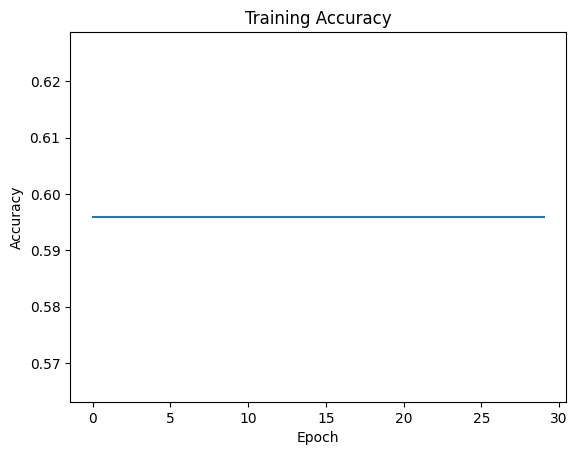

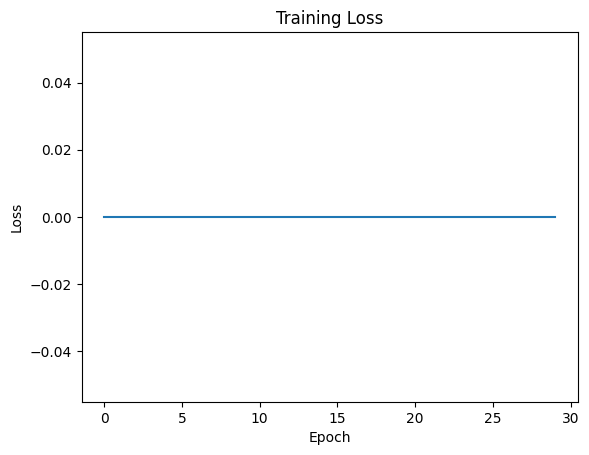

In [12]:
#visualization and scores
# training accuracy
#did not converage 
    #few reasons why i think it happened
    # - data augmentation is not included here
    # - hyperparamters must be adjusted; Epochs, neurons, learning rate, batch size, 
plt.plot(training_results.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# training loss
plt.plot(training_results.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
#TODO test the model
#need to talk to team about questions on how the validation dataset will be split 